In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datasets
from data_analysis import read_steering_results, plot_steering_results,read_steering_results_from_hub, read_steering_results_from_hub_multiproc,DIR
from huggingface_hub import hf_hub_download,snapshot_download
import os
import sys
os.environ['PYTHONPATH'] = '/home/franlucc/projects/codetrace'
sys.path.insert(0, os.environ['PYTHONPATH'])
from codetrace.utils import *

os.environ["HF_HUB_DISABLE_PROGRESS_BARS"]="true"
datasets.disable_progress_bars()

/mnt/ssd/franlucc/envs/interp/lib/python3.10/site-packages/transformers/utils/hub.py:128: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [3]:
#prefetch
cache_dir = snapshot_download(repo_id="nuprl-staging/type-steering-results", repo_type="dataset", local_dir="/tmp/cached_steering_results")
cache_dir

Fetching 821 files:   0%|          | 0/821 [00:00<?, ?it/s]

'/tmp/cached_steering_results'

In [4]:
qwen_results, missing_results = read_steering_results_from_hub_multiproc("py","qwen2p5_coder_7b_base",28,5, cache_dir = cache_dir, num_proc=40)
print(qwen_results, missing_results)

Applying: 100%|██████████| 42/42 [00:24<00:00,  1.74it/s]


                                                   key  \
0                   archives/JakuJ_Stalky.zip/fbapi.py   
1    archives/vmarceau_strava-flow.zip/strava_flow/...   
2    archives/lwohlhart_oaho.zip/utils/test_playgro...   
3    archives/hfjn_envelope.zip/envelope/cli/comman...   
4    archives/Zenith00_aur-sync.zip/aursync/flatten...   
..                                                 ...   
827                                                NaN   
828                                                NaN   
829                                                NaN   
830                                                NaN   
831                                                NaN   

                                                prefix  \
0    import requests\nimport fetcher\nimport sqlite...   
1    import webbrowser\nfrom urllib.parse import ur...   
2    import tensorflow as tf\nimport numpy as np\ni...   
3    import sys\nfrom pathlib import Path\nfrom typ...   
4    import t

In [9]:
qwen_results.columns

Index(['key', 'prefix', 'suffix', 'middle', 'correct', 'model', 'fim_type',
       'fim_program', 'hexsha', 'generated_text', 'mutation_names',
       'mutated_program', '_generated', 'mutated_generated_text', 'model_name',
       'typechecks', 'errors', '_original_program', 'steered_predictions',
       'rand_key', 'rand_prefix', 'rand_suffix', 'rand_middle', 'rand_correct',
       'rand_model', 'rand_fim_type', 'rand_fim_program', 'rand_hexsha',
       'rand_generated_text', 'rand_mutation_names', 'rand_mutated_program',
       'rand__generated', 'rand_mutated_generated_text', 'rand_model_name',
       'rand_typechecks', 'rand_errors', 'rand__original_program',
       'rand_steered_predictions', 'steering_key', 'steering_prefix',
       'steering_suffix', 'steering_middle', 'steering_correct',
       'steering_model', 'steering_fim_type', 'steering_fim_program',
       'steering_hexsha', 'steering_generated_text', 'steering_mutation_names',
       'steering_mutated_program', 'steerin

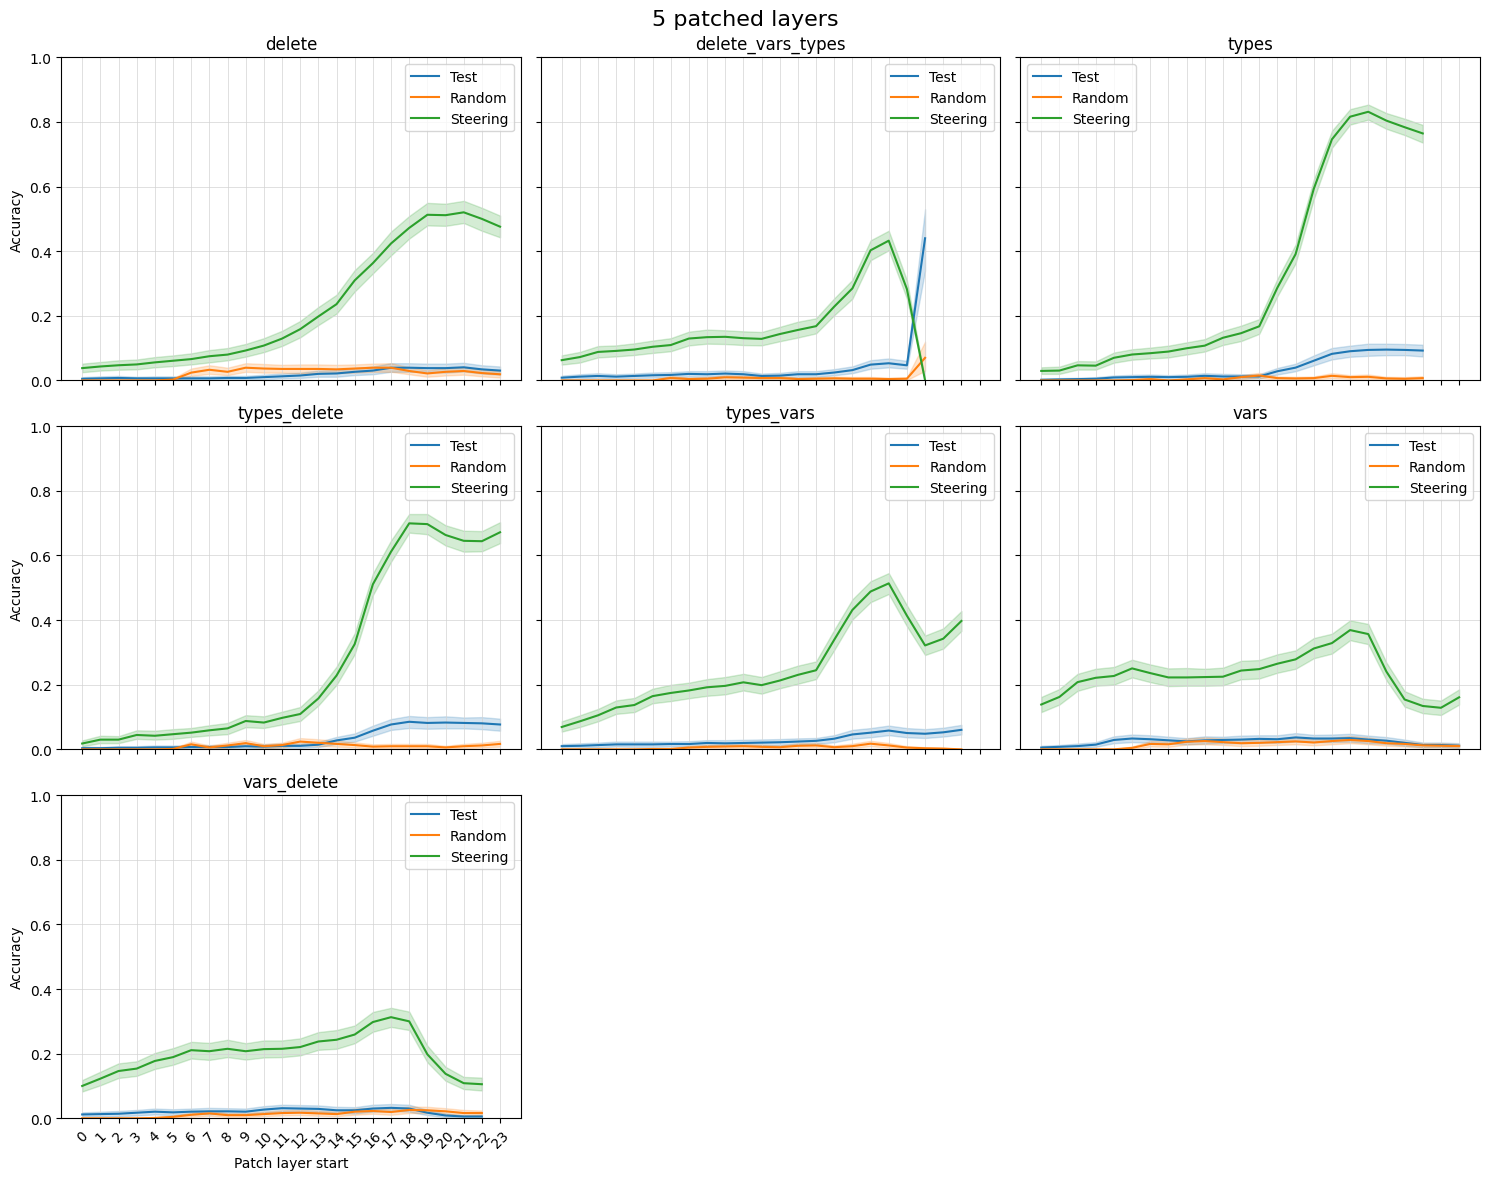

In [12]:
plot_steering_results(qwen_results, 5)